# Assignment 1 – Classification & Regression

Welcome to assignment 1! In this notebook we will help with some parts of the code and the rest is for you to fill in. If you find any errors, or have any feedback, please contact `joelwall@kth.se` or `mats.persson@mi.physics.kth.se`.

In [3]:
# Make sure you have installed the required packages in your Python environment
# It is recommended to use a virtual environment for this e.g. via conda or venv

# If you are having problems with the kernel crashing upon plotting, restart the kernel and uncomment the following two lines:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn
import numpy as np
import scipy
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

torch.manual_seed(42)  # for reproducibility

We begin by loading the data. Make sure that `measuredData.mat` is in the same folder as your notebook or change the path below 

In [5]:
data = scipy.io.loadmat(r"C:\Users\T480s\OneDrive\Documents\aKTH\KTH Second Year\ML_physics\SH2150_assignments\assignment1\measuredData.mat")

To be able to classify all points as class A or class B, we will model the targets $y$ for the data points for which we know the ground truth, using one-hot encoding and then perform binary classification.

If a particle belong to class A we let $y=1$, and if it belongs to class B we let $y=0$. Thus, the one-hot encoding can be though of as modelling the probability $p$ of belonging to class A as a delta distribution over the target, whereas the probability of belonging to class B is modelled as $1 - p$.

Let's create the targets for the known data points as a common vector of one-hot encoded entries

In [6]:
# create labels: 1 = class A, 0 = class B
y_A = np.ones(data['EMeas1'].shape[1])
y_B = np.zeros(data['EMeas2'].shape[1])

# print (data['EMeas1'])

# concatenate the labels to a single target vector
y_train = np.concatenate((y_A, y_B))

# convert to torch tensor and float
y_train = torch.tensor(y_train, dtype=torch.float32)

# print('y_A shape:', y_B.shape)
print('y_train shape:', y_train.shape)

y_train shape: torch.Size([100])


Lets set up the corresponding inputs, and the unknown inputs that does not have any labels / targets yet

In [7]:
theta_A = data['theta1'].squeeze()
theta_B = data['theta2'].squeeze()
theta_train = np.concatenate((theta_A, theta_B))

energy_A = data['EMeas1'].squeeze()
energy_B = data['EMeas2'].squeeze()
energy_train = np.concatenate((energy_A, energy_B))

# stack to one training input matrix
x_train = np.vstack((theta_train, energy_train)).T
x_train = torch.tensor(x_train, dtype=torch.float32)

theta_test = data['thetaUnknown']
energy_test = data['EMeasUnknown']

x_test = np.vstack((theta_test, energy_test)).T
x_test = torch.tensor(x_test, dtype=torch.float32)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: torch.Size([100, 2])
x_test shape: torch.Size([870, 2])


Now lets plot the dataset to get a feeling of what we have to work with. We have a couple of data points that we know belongs to either class A or B. But for the majority of points, we don't know.

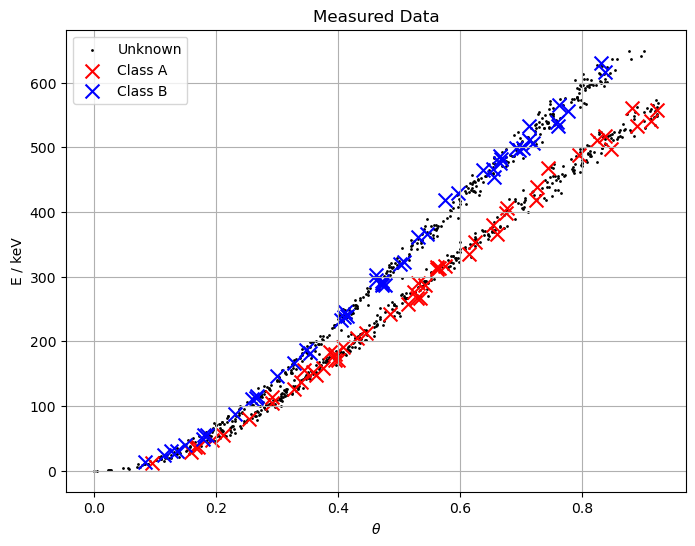

In [8]:
def plot_data():
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(theta_test, energy_test, c='black', s=1, label='Unknown')
    ax.scatter(theta_A, energy_A, c='red', s=100, marker='x', label='Class A')
    ax.scatter(theta_B, energy_B, c='blue', s=100, marker='x', label='Class B')
    ax.set_ylabel('E / keV')
    ax.set_xlabel(r'$\theta$')
    ax.set_title('Measured Data')
    ax.grid()
    ax.legend()
    return fig, ax

plot_data()
plt.show()

# Part 1: The logistic regression model

We begin by defining the model for our logistic regression task. Given $x$, it should return
$$
y = \sigma(\mathbf{W}x+b),
$$
where $$\sigma(x) = \frac{1}{1+e^{-x}}$$
is the logistic (sigmoid) function and $\mathbf{W},b$ are the model parameters. 

For each data point, we will have two input variables ($\theta$, $E$) and one output variable (probability of belonging to class A), hence $x\in\mathbb{R}^2$, $y \in [0,1]$, $\mathbf{W} \in \mathbb{R}^{1 \times 2}$, and $b \in \mathbb{R}$.

We define the model as a class in line with how you would define neural network models using PyTorch.

In [19]:
class LogisticRegression(nn.Module): # We inherit from nn.Module to make torch understand that this is a model
    
    # In the init method, we define all parameters of the model
    def __init__(self, in_features=2, out_features=1):
        super().__init__()

        # nn.Parameter defines a learnable parameter in torch, it can be optimized during training
        self.W = nn.Parameter(torch.zeros(in_features, out_features))
        self.b = nn.Parameter(torch.ones(out_features))

    # Every PyTorch model must have a forward method: 
    # this defines how the model operates on input data.
    def forward(self, x): 
        # y = 1 / (1 + np.exp(-(self.W) @ x + self.b)) # TODO: implement the forward pass according to the logistic regression model
        y = torch.sigmoid(x @ self.W + self.b)
        return y
    
    # Predict method to output class labels based on a threshold of 0.5
    @torch.no_grad()
    def predict(self, x):
        self.eval()
        y_pred = self.forward(x)
        pred = (y_pred >= 0.5).float()
        self.train()
        return pred
    
    # This method should return the decision boundary for the model
    # Update the code according to your answer to Problem 1b)
    @torch.no_grad() # this decorator makes sure that no gradients are computed when calling this method, this makes it more efficient
    def decision_boundary(self, x):
        theta = x[:,0]
        W = self.W.detach().squeeze()
        b = self.b.detach().squeeze()
        boundary = (-b - (W[0] * x[0])) / W[1] # TODO: update according to your answer to Problem 1b)
        
        return theta, boundary
    


## Cross-entropy loss

We will now define the CE loss function to use it as an objective in the fitting of the model. Insert the definition of the CE loss below (see equation 1 in the assignment sheet for a definition)

In [20]:
def cross_entropy_loss(y_pred, y_true):
    # y_pred is same as y_hat, can be anything from [0, 1]
    # y_true is the same as y, real outcome only 0 OR 1

    # Ensure y_pred is clamped to avoid log(0)
    y_pred = torch.clamp(y_pred, 1e-7, 1 - 1e-7)
    
    # Compute binary cross-entropy loss
    loss = - (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred)) # TODO: implement cross-entropy loss, you can use torch.log
    
    # Return mean loss over all samples
    return loss.mean()

## Fitting the model

Lets now combine the model and the loss function to find good parameter estimates. We will use the built-in Adam optimizer `torch.optim.Adam` in PyTorch to minimize the loss function.

In [21]:
def fit_model(model, optimizer, x_train, y_train, loss_fn, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        # Forward pass: compute predicted y by passing x to the model
        y_pred = model(x_train)
        y_pred = y_pred.squeeze()  # Remove singleton dimension

        # Compute loss
        loss = loss_fn(y_pred, y_train)

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 1000 == 0:
            print(f'Epoch {epoch+1:0>{len(str(num_epochs))}}/{num_epochs}, Loss: {loss.item():.4f}', end='\r')


In [22]:
logistic_model = LogisticRegression()
optimizer = torch.optim.Adam(logistic_model.parameters(), lr=10e-2) # TODO: set learning rate
num_epochs = 10_000
fit_model(logistic_model, optimizer, x_train, y_train, cross_entropy_loss, num_epochs)

ValueError: x and y must have same first dimension, but have shapes (100,) and (2,)

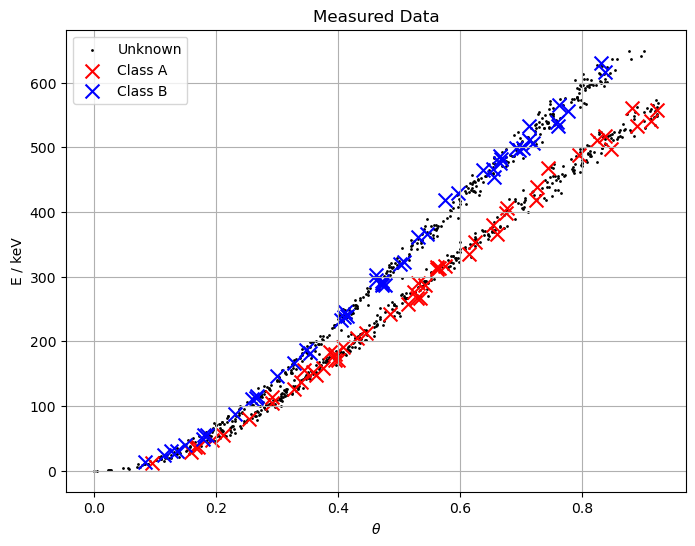

In [23]:
# Plot data again
fig, ax = plot_data()

# Plot decision boundary
ax.plot(*logistic_model.decision_boundary(x_train), c='green', label='Decision Boundary')
ax.legend()

plt.show()

# Part 2: neural network

We shall now try to find a neural network based classifier and see how that affects the decision boundary. We use the built-in `nn.Linear` to define a neural network layer corresponding to the function $x \mapsto \mathbf{W}x + b$ that we explicitly defined above.

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, in_features=2, hidden_features=[10], out_features=1):
        super(NeuralNet, self).__init__()

        layers = []
        
        # Input → first hidden layer
        layers.append(nn.Linear(in_features, hidden_features[0]))
        layers.append( ) # TODO: add tanh activation
        
        # Hidden → hidden
        for i in range(len(hidden_features) - 1):
            layers.append(nn.Linear(hidden_features[i], hidden_features[i + 1]))
            layers.append() # TODO: add tanh activation
        
        # Last hidden → output layer with Sigmoid activation
        layers.append( ) # TODO: add linear layer with input dimension hidden_features[-1] and output dimension out_features
        layers.append(nn.Sigmoid())

        # Build the full network
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
        
    @torch.no_grad()
    def predict(self, x):
        self.eval()
        y_pred = self.forward(x)
        pred = (y_pred >= 0.5).float()
        self.train()
        return pred
    
    @torch.no_grad()
    def decision_boundary(self, x):
        # For neural networks, we typically cannot derive a closed-form decision boundary
        # Here, we will compute the boundary numerically
        theta_vals = torch.linspace(theta_train.min(), theta_train.max(), steps=200)
        energy_vals = torch.linspace(energy_train.min(), energy_train.max(), steps=200)
        grid_theta, grid_energy = torch.meshgrid(theta_vals, energy_vals, indexing='ij')
        grid_points = torch.vstack([grid_theta.ravel(), grid_energy.ravel()]).T
        outputs = self.predict(grid_points).reshape(grid_theta.shape)

        # compute vertical and horizontal diffs
        diff_y = outputs.diff(dim=0).abs()
        diff_x = outputs.diff(dim=1).abs()

        # pad them to restore original shape
        diff_y = nn.functional.pad(diff_y, (0, 0, 0, 1))  # pad one row at bottom
        diff_x = nn.functional.pad(diff_x, (0, 1, 0, 0))  # pad one column at right

        # Find the contour where output probability is 0.5
        boundary_indices = (diff_y.bool() | diff_x.bool())
        
        boundary_theta = grid_theta[boundary_indices]
        boundary_energy = grid_energy[boundary_indices]
        
        return boundary_theta, boundary_energy

Make sure you get a reasonable fit of the model. Try running the code below a couple of times to ensure you get a good fit.

In [ ]:
nn_model = NeuralNet(hidden_features=) # TODO: insert the hidden layer dimensions as a python list, [10] would yield one hidden layer with 10 neurons
optimizer_nn = torch.optim.Adam(nn_model.parameters(), lr=) # TODO: set learning rate
num_epochs = # TODO: set number of epochs
fit_model(nn_model, optimizer_nn, x_train, y_train, cross_entropy_loss, num_epochs)

In [ ]:
fig, axs = plot_data()

# Plot decision boundary
axs.plot(???, c='green', label='Decision Boundary') #TODO: Fill in ???
axs.legend()    
plt.show()

# Part 3: Regression on the energy of the two particles

We will now predict the class of each test data point using one of our classifiers trained above. Then we will fit one curve to each of these classes in order to estimate the two energies.

We begin by classfying the data points

In [ ]:
classifier_model =  # TODO: choose what model to use for classification; nn_model or logistic_model
y_pred = classifier_model.predict(x_test)

pred_A = x_test[y_pred.squeeze() == 1]
pred_B = x_test[y_pred.squeeze() == 0]

theta_pred_A = pred_A[:, 0]
theta_pred_B = pred_B[:, 0]

energy_pred_A = pred_A[:, 1]
energy_pred_B = pred_B[:, 1]

# Plot the classified test data
plt.scatter(theta_pred_A, energy_pred_A, c='red', s=1, label='Predicted Class A')
plt.scatter(theta_pred_B, energy_pred_B, c='blue', s=1, label='Predicted Class B')
plt.ylabel('E')
plt.xlabel(r'$\theta$')
plt.title('Predicted Classes by Classifier')
plt.legend()
plt.show()

We compute the variables used in the Taylor expansion

In [ ]:
t_A = # TODO: define the Taylor variable: 1 - cos(theta) for class A, you can use torch.cos
t_B = # TODO: define the Taylor variable: 1 - cos(theta) for class B

In [ ]:
# TODO: Make a similar plot as above but this time of energy vs transformed angle. Don't forget legend and labels on the axes.
plt.title('Energy vs Transformed Angle')
plt.legend()
plt.show()

Here we set up a regression model to fit against the data in order to extract numerical estimates of the Taylor coefficients

In [ ]:
class RegressionModel(nn.Module):
    def __init__(self, in_features=3, out_features=1):
        super(RegressionModel, self).__init__()
        self.W = nn.Linear(in_features, out_features, bias=False) # no bias term b (we'll just use W)

    def forward(self, x):
        out = torch.stack([x, x**2, x**3], dim=1)
        out = # TODO: apply the linear layer self.W to the features
        return out

We define one model per class and fit them

In [ ]:

model_A = RegressionModel()
model_B = RegressionModel()

optimizer_A = torch.optim.Adam(model_A.parameters(), lr=1e3)
optimizer_B = torch.optim.Adam(model_B.parameters(), lr=1e3)

loss_fn = # TODO: define what loss function to use for the regression

num_epochs = # TODO: define number of epochs 

fit_model(model_A, optimizer_A, t_A, energy_pred_A, loss_fn, num_epochs)
fit_model(model_B, optimizer_B, t_B, energy_pred_B, loss_fn, num_epochs)

and plot the results

In [ ]:
plt.figure(figsize=(10,6))
x_range = torch.linspace(0, t_A.max(), 200)

with torch.no_grad():
    energy_fit_A = model_A(x_range).squeeze()
    energy_fit_B = model_B(x_range).squeeze()

# TODO: Make a similar plot as above, but this time also include curves showing the fitted energy for each class. Don't forget legend and labels on the axes. 
#Suggested title: 'Prediction for Each Class'



And finally we compute the energy estimates by rewriting the found coefficients in terms of the incident energy via the formula for the Taylor coefficients

In [ ]:
def convert_coeff_to_energy(coeff, order):
    # coeff: the coefficient from the Taylor expansion
    # order: the order of the term (1 for linear, 2 for quadratic, etc.)
    E_estimate = # TODO: implement the conversion from Taylor coefficient to energy estimate
    return E_estimate

coeffs_A = model_A.W.weight.data.squeeze()
coeffs_B = model_B.W.weight.data.squeeze()

estimated_energy_A = ??? # TODO: calculate the estimated energy, using the linear fitted term.
estimated_energy_B = ??? # TODO: calculate the estimated energy, using the linear fitted term.

print(f"Estimated Energy for Class A: {estimated_energy_A:.2f} keV")
print(f"Estimated Energy for Class B: {estimated_energy_B:.2f} keV")